# **1. 데이터 불러오기**

In [ ]:
import numpy as np
import pandas as pd
import warnings

from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model
from keras.models import load_model

warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
d_ent_final = pd.read_csv('/content/drive/MyDrive/Wello+project_신희택,윤다솜/Data/기업 데이터 최종/d_ent_final.csv')
p_ent_final = pd.read_csv('/content/drive/MyDrive/Wello+project_신희택,윤다솜/Data/정책 데이터 최종/new_p_ent_final.csv')
concat_rating = pd.read_csv('/content/drive/MyDrive/Wello+project_신희택,윤다솜/Data/정책 데이터 최종/concat_rating.csv')
model = load_model('/content/drive/MyDrive/Wello+project_신희택,윤다솜/3. Modeling/model1.h5')

# **2. 매칭 클래스**

In [ ]:
class MATCHING():
    def __init__(self,d_ent_final,p_ent_final,concat_rating, model, sector,scale,area_sido,area_sigungu,support):
        self.d_ent_final = d_ent_final
        self.p_ent_final = p_ent_final
        self.concat_rating = concat_rating
        self.sector = sector
        self.scale = scale
        self.area_sido = area_sido
        self.area_sigungu = area_sigungu
        self.support = support
        self.model = model
        
    def RECOMMENDATION(self):

        d_ent_final=self.d_ent_final
        p_ent_final=self.p_ent_final
        concat_rating=self.concat_rating
        sector = self.sector
        scale = self.scale
        area_sido = self.area_sido
        area_sigungu = self.area_sigungu
        support = self.support
        model = self.model

        try:
            dataframe = d_ent_final[(d_ent_final['업종(대분류)']==sector)&(d_ent_final['기업규모']==scale)].reset_index(drop=True)
            # 업종과 기업규모가 해당하는 케이스가 없을 때
            if len(dataframe)==0:
                # 업종과 기업규모 모두 결측값(해당없음)일 때
                if (sector == '해당없음')&(scale == '해당없음'):
                    abc = p_ent_final[p_ent_final['태그-업종(대분류)'].apply(lambda x: x=='무관')]
                    abc = abc[abc['태그-기업규모'].apply(lambda x: x=='무관')]

                    # 지역(시도)도 결측값(해당없음)일 때
                    if area_sido == '해당없음':
                        abc = abc[abc['태그-지역(시도)'].apply(lambda x: x=='전국')]
                        # 지역(시군구)가 결측값일 때
                        if area_sigungu == '해당없음':
                            abc = abc[abc['태그-지역(시군구)'].apply(lambda x: x=='전체')]
                            return abc[abc['태그-지원유형'].apply(lambda x: support in x)]
                        # 지역(시군구)가 결측값이 아닐 때
                        else:
                            abc = abc[abc['태그-지역(시군구)'].apply(lambda x: (area_sigungu in x)|(x=='전체'))]
                            return abc[abc['태그-지원유형'].apply(lambda x: support in x)]
                    # 지역(시도)는 결측값이 아닐 때
                    else:
                        abc = abc[abc['태그-지역(시도)'].apply(lambda x: (area_sido in x)|(x=='전국'))]
                        # 지역(시군구)가 결측값일 때
                        if area_sigungu == '해당없음':
                            abc = abc[abc['태그-지역(시군구)'].apply(lambda x: x=='전체')]
                            return abc[abc['태그-지원유형'].apply(lambda x: support in x)]
                        # 지역(시군구)가 결측값이 아닐 때
                        else:
                            abc = abc[abc['태그-지역(시군구)'].apply(lambda x: (area_sigungu in x)|(x=='전체'))]
                            return abc[abc['태그-지원유형'].apply(lambda x: support in x)]
                # 업종 값이 있고 기업규모는 결측값일 때        
                elif (sector != '해당없음')&(scale == '해당없음'):
                    abc = p_ent_final[p_ent_final['태그-업종(대분류)'].apply(lambda x: sector in x)]
                    abc = abc[abc['태그-기업규모'].apply(lambda x: x=='무관')]
                    # 지역(시도)도 결측값(해당없음)일 때
                    if area_sido == '해당없음':
                        abc = abc[abc['태그-지역(시도)'].apply(lambda x: x=='전국')]
                        abc = abc[abc['태그-지원유형'].apply(lambda x: support in x)]
                        
                        abc['태그-업종(대분류)스플릿'] = abc['태그-업종(대분류)'].apply(lambda x: x.split('/'))
                        a0 =  abc[(abc['태그-업종(대분류)'].apply(lambda x: sector in x))&(abc['태그-업종(대분류)스플릿'].apply(lambda x: len(x)==1))]
                        a1 =  abc[(abc['태그-업종(대분류)'].apply(lambda x: sector in x))&(abc['태그-업종(대분류)스플릿'].apply(lambda x: len(x)==2))]
                        a2 =  abc[(abc['태그-업종(대분류)'].apply(lambda x: sector in x))&(abc['태그-업종(대분류)스플릿'].apply(lambda x: len(x)==3))]
                        a3 = abc[abc['태그-업종(대분류)'].apply(lambda x: sector in x)]
                        new = pd.concat([a0,a1,a2,a3]).reset_index(drop=True).drop(['태그-업종(대분류)스플릿'],axis=1)
                        return new.drop_duplicates(['서비스명'],keep='first')
                    # 지역(시도)는 결측값이 아닐 때
                    else:
                        abc = abc[abc['태그-지역(시도)'].apply(lambda x: (area_sido in x)|(x=='전국'))]
                        # 지역(시군구)가 결측값일 때
                        if area_sigungu == '해당없음':
                            abc = abc[abc['태그-지역(시군구)'].apply(lambda x: x=='전체')]
                            abc = abc[abc['태그-지원유형'].apply(lambda x: support in x)]
                            abc['태그-업종(대분류)스플릿'] = abc['태그-업종(대분류)'].apply(lambda x: x.split('/'))
                            a0 =  abc[(abc['태그-업종(대분류)'].apply(lambda x: sector in x))&(abc['태그-업종(대분류)스플릿'].apply(lambda x: len(x)==1))]
                            a1 =  abc[(abc['태그-업종(대분류)'].apply(lambda x: sector in x))&(abc['태그-업종(대분류)스플릿'].apply(lambda x: len(x)==2))]
                            a2 =  abc[(abc['태그-업종(대분류)'].apply(lambda x: sector in x))&(abc['태그-업종(대분류)스플릿'].apply(lambda x: len(x)==3))]
                            a3 = abc[abc['태그-업종(대분류)'].apply(lambda x: sector in x)]
                            new = pd.concat([a0,a1,a2,a3]).reset_index(drop=True).drop(['태그-업종(대분류)스플릿'],axis=1)
                            return new.drop_duplicates(['서비스명'],keep='first')
                        # 지역(시군구)가 결측값이 아닐 때
                        else:
                            abc = abc[abc['태그-지역(시군구)'].apply(lambda x: (area_sigungu in x)|(x=='전체'))]
                            abc = abc[abc['태그-지원유형'].apply(lambda x: support in x)]
                            abc['태그-업종(대분류)스플릿'] = abc['태그-업종(대분류)'].apply(lambda x: x.split('/'))
                            a0 =  abc[(abc['태그-업종(대분류)'].apply(lambda x: sector in x))&(abc['태그-업종(대분류)스플릿'].apply(lambda x: len(x)==1))]
                            a1 =  abc[(abc['태그-업종(대분류)'].apply(lambda x: sector in x))&(abc['태그-업종(대분류)스플릿'].apply(lambda x: len(x)==2))]
                            a2 =  abc[(abc['태그-업종(대분류)'].apply(lambda x: sector in x))&(abc['태그-업종(대분류)스플릿'].apply(lambda x: len(x)==3))]
                            a3 = abc[abc['태그-업종(대분류)'].apply(lambda x: sector in x)]
                            new = pd.concat([a0,a1,a2,a3]).reset_index(drop=True).drop(['태그-업종(대분류)스플릿'],axis=1)
                            return new.drop_duplicates(['서비스명'],keep='first')
                # 업종이 결측값이고 기업규모는 값이 있을 때
                elif (sector == '해당없음')&(scale != '해당없음'):
                    abc = p_ent_final[p_ent_final['태그-업종(대분류)'].apply(lambda x: x=='무관')]
                    abc = abc[abc['태그-기업규모'].apply(lambda x: scale in x)]
                    # 지역(시도)도 결측값(해당없음)일 때
                    if area_sido == '해당없음':
                        abc = abc[abc['태그-지역(시도)'].apply(lambda x: x=='전국')]
                        abc = abc[abc['태그-지원유형'].apply(lambda x: support in x)]
                        abc['태그-기업규모스플릿'] = abc['태그-기업규모'].apply(lambda x: x.split('/'))
                        a0 =  abc[(abc['태그-기업규모'].apply(lambda x: scale in x))&(abc['태그-기업규모스플릿'].apply(lambda x: len(x)==1))]
                        a1 =  abc[(abc['태그-기업규모'].apply(lambda x: scale in x))&(abc['태그-기업규모스플릿'].apply(lambda x: len(x)==2))]
                        a2 =  abc[(abc['태그-기업규모'].apply(lambda x: scale in x))&(abc['태그-기업규모스플릿'].apply(lambda x: len(x)==3))]
                        a3 = abc[abc['태그-기업규모'].apply(lambda x: scale in x)]
                        new = pd.concat([a0,a1,a2,a3]).reset_index(drop=True).drop(['태그-기업규모스플릿'],axis=1)
                        return new.drop_duplicates(['서비스명'],keep='first')

                    # 지역(시도)는 결측값이 아닐 때
                    else:
                        abc = abc[abc['태그-지역(시도)'].apply(lambda x: (area_sido in x)|(x=='전국'))]
                        # 지역(시군구)가 결측값일 때
                        if area_sigungu == '해당없음':
                            abc = abc[abc['태그-지역(시군구)'].apply(lambda x: x=='전체')]
                            abc = abc[abc['태그-지원유형'].apply(lambda x: support in x)]
                            abc['태그-기업규모스플릿'] = abc['태그-기업규모'].apply(lambda x: x.split('/'))
                            a0 =  abc[(abc['태그-기업규모'].apply(lambda x: scale in x))&(abc['태그-기업규모스플릿'].apply(lambda x: len(x)==1))]
                            a1 =  abc[(abc['태그-기업규모'].apply(lambda x: scale in x))&(abc['태그-기업규모스플릿'].apply(lambda x: len(x)==2))]
                            a2 =  abc[(abc['태그-기업규모'].apply(lambda x: scale in x))&(abc['태그-기업규모스플릿'].apply(lambda x: len(x)==3))]
                            a3 = abc[abc['태그-기업규모'].apply(lambda x: scale in x)]
                            new = pd.concat([a0,a1,a2,a3]).reset_index(drop=True).drop(['태그-기업규모스플릿'],axis=1)
                            return new.drop_duplicates(['서비스명'],keep='first')
                        # 지역(시군구)가 결측값이 아닐 때
                        else:
                            abc = abc[abc['태그-지역(시군구)'].apply(lambda x: (area_sigungu in x)|(x=='전체'))]
                            abc = abc[abc['태그-지원유형'].apply(lambda x: support in x)]
                            abc['태그-기업규모스플릿'] = abc['태그-기업규모'].apply(lambda x: x.split('/'))
                            a0 =  abc[(abc['태그-기업규모'].apply(lambda x: scale in x))&(abc['태그-기업규모스플릿'].apply(lambda x: len(x)==1))]
                            a1 =  abc[(abc['태그-기업규모'].apply(lambda x: scale in x))&(abc['태그-기업규모스플릿'].apply(lambda x: len(x)==2))]
                            a2 =  abc[(abc['태그-기업규모'].apply(lambda x: scale in x))&(abc['태그-기업규모스플릿'].apply(lambda x: len(x)==3))]
                            a3 = abc[abc['태그-기업규모'].apply(lambda x: scale in x)]
                            new = pd.concat([a0,a1,a2,a3]).reset_index(drop=True).drop(['태그-기업규모스플릿'],axis=1)
                            return new.drop_duplicates(['서비스명'],keep='first')
                # 업종과 기업규모가 모두 결측값이 아닌데 해당 기업이 없을 경우
                else:
                    # 업종 값이랑 기업 값 모두 있을 때
                    
                    abc = p_ent_final[p_ent_final['태그-업종(대분류)'].apply(lambda x: (sector in x)|(sector=='무관'))]
                    abc = abc[abc['태그-기업규모'].apply(lambda x: (scale in x)|(x=='무관'))]
                    # 지역(시도)도 결측값(해당없음)일 때
                    if area_sido == '해당없음':
                        abc = abc[abc['태그-지역(시도)'].apply(lambda x: x=='전국')]
                        abc = abc[abc['태그-지원유형'].apply(lambda x: support in x)]
                        
                        abc['태그-업종(대분류)스플릿'] = abc['태그-업종(대분류)'].apply(lambda x: x.split('/'))
                        a0 =  abc[(abc['태그-업종(대분류)'].apply(lambda x: sector in x))&(abc['태그-업종(대분류)스플릿'].apply(lambda x: len(x)==1))]
                        a1 =  abc[(abc['태그-업종(대분류)'].apply(lambda x: sector in x))&(abc['태그-업종(대분류)스플릿'].apply(lambda x: len(x)==2))]
                        a2 =  abc[(abc['태그-업종(대분류)'].apply(lambda x: sector in x))&(abc['태그-업종(대분류)스플릿'].apply(lambda x: len(x)==3))]
                        a3 = abc[abc['태그-업종(대분류)'].apply(lambda x: sector in x)]
                        new = pd.concat([a0,a1,a2,a3]).reset_index(drop=True).drop(['태그-업종(대분류)스플릿'],axis=1)
                        return new.drop_duplicates(['서비스명'],keep='first')
                    # 지역(시도)는 결측값이 아닐 때
                    else:
                        abc = abc[abc['태그-지역(시도)'].apply(lambda x: (area_sido in x)|(x=='전국'))]
                        # 지역(시군구)가 결측값일 때
                        if area_sigungu == '해당없음':
                            abc = abc[abc['태그-지역(시군구)'].apply(lambda x: x=='전체')]
                            abc = abc[abc['태그-지원유형'].apply(lambda x: support in x)]
                            abc['태그-업종(대분류)스플릿'] = abc['태그-업종(대분류)'].apply(lambda x: x.split('/'))
                            a0 =  abc[(abc['태그-업종(대분류)'].apply(lambda x: sector in x))&(abc['태그-업종(대분류)스플릿'].apply(lambda x: len(x)==1))]
                            a1 =  abc[(abc['태그-업종(대분류)'].apply(lambda x: sector in x))&(abc['태그-업종(대분류)스플릿'].apply(lambda x: len(x)==2))]
                            a2 =  abc[(abc['태그-업종(대분류)'].apply(lambda x: sector in x))&(abc['태그-업종(대분류)스플릿'].apply(lambda x: len(x)==3))]
                            a3 = abc[abc['태그-업종(대분류)'].apply(lambda x: sector in x)]
                            new = pd.concat([a0,a1,a2,a3]).reset_index(drop=True).drop(['태그-업종(대분류)스플릿'],axis=1)
                            return new.drop_duplicates(['서비스명'],keep='first')
                        # 지역(시군구)가 결측값이 아닐 때
                        else:
                            abc = abc[abc['태그-지역(시군구)'].apply(lambda x: (area_sigungu in x)|(x=='전체'))]
                            abc = abc[abc['태그-지원유형'].apply(lambda x: support in x)]
                            abc['태그-업종(대분류)스플릿'] = abc['태그-업종(대분류)'].apply(lambda x: x.split('/'))
                            a0 =  abc[(abc['태그-업종(대분류)'].apply(lambda x: sector in x))&(abc['태그-업종(대분류)스플릿'].apply(lambda x: len(x)==1))]
                            a1 =  abc[(abc['태그-업종(대분류)'].apply(lambda x: sector in x))&(abc['태그-업종(대분류)스플릿'].apply(lambda x: len(x)==2))]
                            a2 =  abc[(abc['태그-업종(대분류)'].apply(lambda x: sector in x))&(abc['태그-업종(대분류)스플릿'].apply(lambda x: len(x)==3))]
                            a3 = abc[abc['태그-업종(대분류)'].apply(lambda x: sector in x)]
                            new = pd.concat([a0,a1,a2,a3]).reset_index(drop=True).drop(['태그-업종(대분류)스플릿'],axis=1)
                            return new.drop_duplicates(['서비스명'],keep='first')
                    
            # 업종과 기업규모가 있을 때
            else:
                # 지역(시도)값이 있을 때
                if len(dataframe[dataframe['지역(광역시도)']==area_sido])>=1:
                    dataframe = dataframe[dataframe['지역(광역시도)']==area_sido].reset_index(drop=True)
                    show_d_ent = dataframe.loc[0]
                    
                    # 업종,기업규모,지역(시도)가 같은 기업의 모델링을 통한 관련 정책 추천
                    policy_data = np.array(list(set(concat_rating.정책ID)))
                    enterprise = np.array([show_d_ent['기업ID'] for i in range(len(policy_data))])
                    predictions = model.predict([enterprise, policy_data])
                    predictions = np.array([a[0] for a in predictions])
                    recommended_policy_ids = (-predictions).argsort()

                    # 업종, 지역, 지원유형에 해당하는 데이터 프레임 뽑기
                    abc = p_ent_final[p_ent_final['태그-업종(대분류)'].apply(lambda x: sector in x)]
                    abc = abc[abc['태그-지역(시도)'].apply(lambda x: (x=='전국')|(area_sido in x))]
                    abc = abc[abc['태그-지원유형'].apply(lambda x: support in x)]

                    # 위 프레임에 관련 정책 순서대로 뽑기
                    new = pd.DataFrame(columns=p_ent_final.columns)
                    for i in recommended_policy_ids:
                        new = new.append(abc[abc['정책ID']==i])

                    # 지역(시군구) 값이 있을 때 
                    if len(new[new['태그-지역(시군구)']==area_sigungu])>=1:

                        a0 = new[new['태그-업종(대분류)'].apply(lambda x: x==sector)]
                        a1 = new[new['태그-지역(시군구)'].apply(lambda x: area_sigungu in x)]
                        a2 = new[new['태그-지역(시군구)'].apply(lambda x: x=='전체')]
                        new = pd.concat([a0,a1,a2]).reset_index(drop=True)
                        return new.drop_duplicates(['서비스명'],keep='first')
                    # 지역(시군구) 값이 없을 때    
                    else:
                        a0 = new[new['태그-업종(대분류)'].apply(lambda x: x==sector)]
                        a1 = new[new['태그-업종(대분류)'].apply(lambda x: (sector in x)&(x!=sector))]
                        a2 = new[new['태그-지역(시군구)'].apply(lambda x: x=='전체')]
                        new = pd.concat([a0,a1,a2]).reset_index(drop=True)                   
                        return new.drop_duplicates(['서비스명'],keep='first')

                # 지역(시도)가 없을 때
                else:
                    abc = p_ent_final[p_ent_final['태그-기업규모'].apply(lambda x: (scale in x)|(x=='무관'))] 
                    abc = abc[abc['태그-지원유형'].apply(lambda x: support in x)]
                    abc = abc[abc['태그-지역(시도)'].apply(lambda x: (x=='전국')|(area_sido in x))]
                    abc['태그-업종(대분류)스플릿'] = abc['태그-업종(대분류)'].apply(lambda x: x.split('/'))
                    a0 =  abc[(abc['태그-업종(대분류)'].apply(lambda x: sector in x))&(abc['태그-업종(대분류)스플릿'].apply(lambda x: len(x)==1))]
                    a1 =  abc[(abc['태그-업종(대분류)'].apply(lambda x: sector in x))&(abc['태그-업종(대분류)스플릿'].apply(lambda x: len(x)==2))]
                    a2 =  abc[(abc['태그-업종(대분류)'].apply(lambda x: sector in x))&(abc['태그-업종(대분류)스플릿'].apply(lambda x: len(x)==3))]
                    a3 = abc[abc['태그-업종(대분류)'].apply(lambda x: sector in x)]
                    new = pd.concat([a0,a1,a2,a3]).reset_index(drop=True).drop(['태그-업종(대분류)스플릿'],axis=1)
                    return new.drop_duplicates(['서비스명'],keep='first')
        except:
            print('해당 정책이 없습니다.')

# **3. 구현 예시**

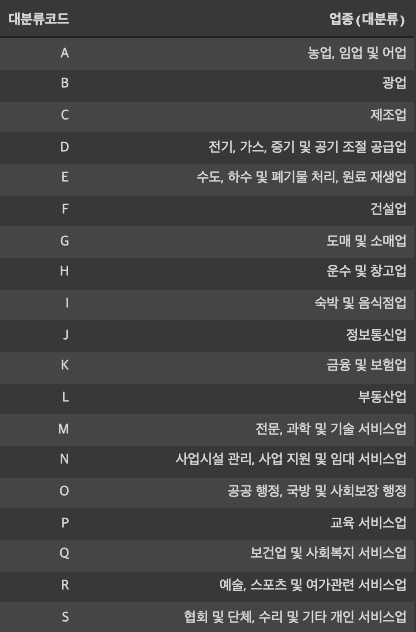

In [ ]:
try0 = MATCHING(d_ent_final,p_ent_final,concat_rating,model,'농업, 임업 및 어업','중소기업','강원도','춘천시','현금,현물')
result = try0.RECOMMENDATION()
result.head(30)